In [ ]:
!pip install -q -U tensorflow-text
!pip install torchvision 
!pip install -q tf-models-official
!pip install transformers

     |████████████████████████████████| 4.6 MB 5.0 MB/s 
     |████████████████████████████████| 511.7 MB 6.4 kB/s 
     |████████████████████████████████| 5.8 MB 55.0 MB/s 
     |████████████████████████████████| 1.6 MB 17.6 MB/s 
     |████████████████████████████████| 438 kB 66.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 5.4 MB/s 
     |████████████████████████████████| 99 kB 11.0 MB/s 
     |████████████████████████████████| 237 kB 52.3 MB/s 
     |████████████████████████████████| 47.8 MB 111 kB/s 
     |████████████████████████████████| 43 kB 2.3 MB/s 
     |████████████████████████████████| 1.1 MB 54.5 MB/s 
     |████████████████████████████████| 1.2 MB 65.8 MB/s 
     |████████████████████████████████| 352 kB 55.3 MB/s 
     |████████████████████████████████| 636 kB 56.7 MB/s 
     |████████████████████████████████| 92 kB 12.9 MB/s 
Looking in indexes: https://pypi.org

In [ ]:
import os
import shutil
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
from official.nlp import optimization  # to create AdamW optimizer
from sklearn import preprocessing
import matplotlib.pyplot as plt
from keras.utils.np_utils import to_categorical

tf.get_logger().setLevel('ERROR')
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast, BertConfig, BertForTokenClassification,BertForSequenceClassification, BertTokenizer,  AdamW
from seqeval.metrics import classification_report
import pickle

import nltk
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from nltk import word_tokenize
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from torch import cuda
device = 'cuda:0' if cuda.is_available() else 'cpu'
print(device)

cuda:0


In [ ]:
path = '/content/drive/MyDrive/train_dataset_catalan_1.xlsx'

In [ ]:
file = pd.read_excel(path)

In [ ]:
file.head()

,username,creation_date,tweet_es,crime_label,crime_category,crime_type,tweet_ca,tweet_processed_es
0,guardiacivil,2017-10-13 20:00:02,"Es indiferente el evento, la fiesta, el lugar,...",Not Crime,0.0,NaN,"L’esdeveniment, la festa, el lloc, el dia, la ...","Es indiferente el evento, la fiesta, el lugar,..."
1,guardiacivil,2022-01-07 14:00:00,El #ServicioAéreo y el #ServiciodeMontaña de l...,Not Crime,0.0,NaN,El #Servicioaéreo i el #Serviciodemontaña del ...,El #ServicioAéreo y el #ServiciodeMontaña de l...
2,guardiacivil,2018-01-23 12:00:02,"""Paco"" arañó un vehículo cuando estaba aparcan...",Not Crime,0.0,NaN,"""Paco"" es va ratllar un vehicle quan estava ap...","""Paco"" arañó un vehículo cuando estaba aparcan..."
3,guardiacivil,2021-06-03 14:00:00,Los requisitos específicos para participar en ...,Not Crime,0.0,NaN,Els requisits específics per participar en el ...,Los requisitos específicos para participar en ...
4,guardiacivil,2018-01-16 08:00:01,"Esta semana el ""grajo va a volar muy bajo"", e ...",Not Crime,0.0,NaN,"Aquesta setmana el ""Grajo volarà molt baix"", i...","Esta semana el ""grajo va a volar muy bajo"", e ..."


In [ ]:
len(file)

4671

In [ ]:
file.crime_label.unique()

array(['Not Crime', 'Crime'], dtype=object)

In [ ]:
file['crime_category'] = 0
for i in range(len(file)):
  if file['crime_label'][i] == 'Crime':
    file['crime_category'][i] = 1

In [ ]:
file.crime_category = file.crime_category.astype(int)

In [ ]:
print('Total Train Tweets:',len(file))
print('Total Train Crime Tweets:',len(file.loc[file['crime_label'] == 'Crime']))
print('Total Train Not Crime Tweets:',len(file.loc[file['crime_label'] == 'Not Crime']))

Total Train Tweets: 4671
Total Train Crime Tweets: 884
Total Train Not Crime Tweets: 3787


In [ ]:
model_name = "PlanTL-GOB-ES/roberta-base-ca" #    projecte-aina/roberta-base-ca-cased-tc
max_length = 512

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=True)

In [ ]:
X = [tweet for tweet in file.tweet_ca]
y = [ label for label in file.crime_category]

# splitting data from training, validation, and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42) 

print("X[0]:", X[0])
print("y[0]:", y[0])

print("Size X_train: ", len(X_train))
print("Size X_valid: ", len(X_valid))
print("Size X_test: ", len(X_test))

X[0]: L’esdeveniment, la festa, el lloc, el dia, la nit o l’hora és indiferent.És senzill: #neesno
Davant de qualsevol agressió, no dubteu a la queixa #062 https://t.co/v1e2czffl
y[0]: 0
Size X_train:  3736
Size X_valid:  467
Size X_test:  468


In [ ]:
from collections import Counter
Counter(y_train)

Counter({0: 3032, 1: 704})

In [ ]:
all_tags = sorted(set(['Not Crime', 'Crime']), reverse=True)
num_tags = len(all_tags)
print("Number of tags:", num_tags)
print("Tags:", all_tags)

Number of tags: 2
Tags: ['Not Crime', 'Crime']


In [ ]:
tag2index = {tag: i for i, tag in enumerate(all_tags)}
index2tag = {i: tag for tag, i in tag2index.items()}

In [ ]:
print(index2tag)

{0: 'Not Crime', 1: 'Crime'}


In [ ]:
class dataset(Dataset):
  def __init__(self, X, y, tokenizer, max_len):
        self.len = len(X)
        self.X = X
        self.y = y
        self.tokenizer = tokenizer
        self.max_len = max_len

  def __len__(self):
        return self.len

  def __getitem__(self, index):
        # step 1: get the sentence and word labels 
        text = self.X[index]
        label = self.y[index]

        # step 2: use tokenizer to encode sentence (includes padding/truncation up to max length)
        # BertTokenizerFast provides a handy "return_offsets_mapping" functionality for individual tokens
        encoding = self.tokenizer(text,
                             padding='max_length', max_length = self.max_len, 
                              truncation=True, return_tensors="pt")
        encoding['label'] = torch.tensor(label)
        return encoding

In [ ]:
max_seq_len = 128
training_set = dataset(X_train, y_train, tokenizer, max_seq_len)
validation_set = dataset(X_valid, y_valid, tokenizer, max_seq_len)
testing_set = dataset(X_test, y_test, tokenizer, max_seq_len)

In [ ]:
training_set[0]

{'input_ids': tensor([[    0,   607,    80,   264,  9297, 27452,  1409, 50622,   295,   517,
           784,  9509,   263,   607,    48,   202,    11, 14286,   274,   288,
           539, 18465,  3546,    15,   285,   863,   377,    80,   263,  4706,
            51,   314,  2438,   301, 44970,   583,   365,   492,   401,  1745,
           447,  2907,    12, 11461,  4615,    87,    17,  2018,    18,    20,
            77,    71,    84,    26,    77,    54,    92,    78,    20,     2,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,  

In [ ]:
max_seq_len = max([len(x) for x in X])
print("max_seq_leng:", max_seq_len)

max_seq_leng: 345


In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(tag2index),ignore_mismatched_sizes=True)
model = model.to(device)

Downloading:   0%|          | 0.00/481M [00:00<?, ?B/s]

Some weights of the model checkpoint at PlanTL-GOB-ES/roberta-base-ca were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-ca and are newly initialized: ['classifier.dense.weight', 'classifier.

In [ ]:
TRAIN_BATCH_SIZE = 40
VALID_BATCH_SIZE = 40
EPOCHS = 10

training_loader = DataLoader(training_set, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(validation_set, batch_size=VALID_BATCH_SIZE, shuffle=False)
testing_loader = DataLoader(testing_set, batch_size=VALID_BATCH_SIZE, shuffle=False)

In [ ]:
inputs = { key: training_set[:10][key] for key in ['input_ids','attention_mask','label'] }
ids = inputs['input_ids'].to(device)
mask = inputs['attention_mask'].to(device)

labels =inputs['label'].to(device)

outputs = model(input_ids=ids,attention_mask=mask,labels=labels)
initial_loss = outputs[0]
initial_loss

tensor(0.6576, device='cuda:0', grad_fn=<NllLossBackward0>)

In [ ]:
tr_logits = outputs[1]
tr_logits

tensor([[-0.0806, -0.1266],
        [-0.0102, -0.1381],
        [-0.0242, -0.0645],
        [-0.1139, -0.1823],
        [-0.0660, -0.1288],
        [-0.0575, -0.1765],
        [-0.0549, -0.1455],
        [-0.0762, -0.1063],
        [-0.1557, -0.1679],
        [-0.0771, -0.2090]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
optimizer = AdamW(model.parameters(),lr = 2e-5, eps = 1e-8 )

In [ ]:
from pandas._libs.index import BaseMultiIndexCodesEngine
def valid(model, data_loader):
    # put model in evaluation mode
    model.eval()
    
    eval_loss, eval_accuracy = 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds, eval_labels = [], []
    
    with torch.no_grad():
        for idx, batch in enumerate(data_loader):

            ids = batch['input_ids'].squeeze().to(device)
            mask = batch['attention_mask'].squeeze().to(device)
            labels = batch['label'].to(device)
            
            outputs = model(input_ids=ids,attention_mask=mask,labels=labels)  
            loss = outputs[0]
            eval_logits = outputs[1]
            
            eval_loss += loss.item()

            nb_eval_steps += 1
            nb_eval_examples += labels.size(0)
        
            # if idx % 100==0:
            #     loss_step = eval_loss/nb_eval_steps
            #     print(f"Validation loss per 100 evaluation steps: {loss_step}")
              
            # compute evaluation accuracy
            flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
            active_logits = eval_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
            
            # only compute accuracy at active labels
            active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        
            labels = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)
            
            eval_labels.extend(labels)
            eval_preds.extend(predictions)
            
            tmp_eval_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
            eval_accuracy += tmp_eval_accuracy

    labels = [index2tag[id.item()] for id in eval_labels]
    predictions = [index2tag[id.item()] for id in eval_preds]
    
    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_steps

    # print(f"Validation : loss {eval_loss:.2f} accuracy {eval_accuracy:.2f}")

    return labels, predictions, eval_loss, eval_accuracy

In [ ]:
def train(epoch):
    tr_loss, tr_accuracy = 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_preds, tr_labels = [], []
    # put model in training mode
    model.train()
    with tqdm(training_loader, 'batch') as tepoch:
        for idx, batch in enumerate(tepoch):
            tepoch.set_description(f'Epoch {epoch}')
            
            ids = batch['input_ids'].squeeze().to(device)
            mask = batch['attention_mask'].squeeze().to(device)
            labels = batch['label'].to(device)
            
            outputs = model(input_ids=ids,attention_mask=mask,labels=labels)  

            loss, tr_logits = outputs[0], outputs[1]
            tr_loss += loss.item()

            nb_tr_steps += 1
            nb_tr_examples += labels.size(0)
            
            # if idx % 100==0:
            #     loss_step = tr_loss/nb_tr_steps
            #     print(f"Training loss per 100 training steps: {loss_step:.2f}")
            
            # compute training accuracy
            flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
            active_logits = tr_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
          
    
            # only compute accuracy at active labels
            active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
            #active_labels = torch.where(active_accuracy, labels.view(-1), torch.tensor(-100).type_as(labels))
            
            labels = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)

            tr_labels.extend(labels)
            tr_preds.extend(predictions)

            tmp_tr_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
            tr_accuracy += tmp_tr_accuracy
        
            # gradient clipping
            torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=10)
            
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            tepoch.set_postfix(loss=tr_loss / nb_tr_steps, accuracy=tr_accuracy / nb_tr_steps)
    
    epoch_loss = tr_loss / nb_tr_steps
    tr_accuracy = tr_accuracy / nb_tr_steps
              
    _, _ , val_loss, val_acc = valid(model, validation_loader)
    
    return epoch_loss, tr_accuracy, val_loss, val_acc

In [ ]:
history = {'train_loss':[], 'train_accuracy':[], 'val_loss':[], 'val_accuracy':[], 'epoch':[]}
for epoch in range(EPOCHS):
    train_loss, train_acc, val_loss, val_acc = train(epoch)
    
    history['train_loss'].append(train_loss)
    history['train_accuracy'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_acc)
    history['epoch'].append(epoch+1)

Epoch 9: 100%|██████████| 94/94 [01:14<00:00,  1.27it/s, accuracy=0.997, loss=0.0105]


<function matplotlib.pyplot.show>

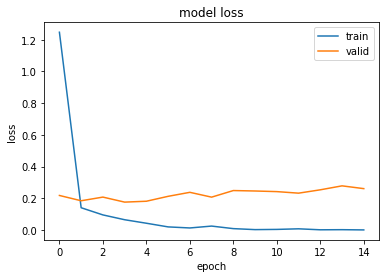

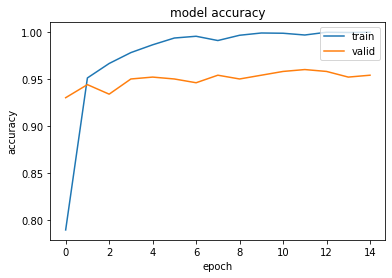

In [ ]:
plt.figure(1)
plt.plot(history[f'train_loss'])
plt.plot(history[f'val_loss'])
plt.title(f'model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show

plt.figure(2)
plt.plot(history[f'train_accuracy'])
plt.plot(history[f'val_accuracy'])
plt.title(f'model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show

In [ ]:
from sklearn.metrics import classification_report

labels, predictions, loss, accuracy = valid(model, testing_loader)
print(f"Validation : loss {loss:.2f} accuracy {accuracy:.2f}")
print(classification_report(labels, predictions))

Validation : loss 0.18 accuracy 0.97
              precision    recall  f1-score   support

       Crime       0.99      0.85      0.92        95
   Not Crime       0.96      1.00      0.98       373

    accuracy                           0.97       468
   macro avg       0.98      0.92      0.95       468
weighted avg       0.97      0.97      0.97       468



In [ ]:
not_classified = []
for i in range(len(labels)): 
  if labels[i] != predictions[i]:
    not_classified.append(i)  

In [ ]:
len(not_classified)

15

In [ ]:
def inference(sentence, tokenizer):
    inputs = tokenizer(sentence,padding='max_length', max_length = 128, truncation=True, return_tensors="pt")

    # move to gpu
    ids = inputs["input_ids"].to(device)
    mask = inputs["attention_mask"].to(device)
    # forward pass
    outputs = model(ids, attention_mask=mask)
    logits = outputs[0]

    active_logits = logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
    flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size*seq_len,) - predictions at the token level

    tokens = tokenizer.convert_ids_to_tokens(ids.squeeze().tolist())
    
    token_predictions = [index2tag[i] for i in flattened_predictions.cpu().numpy()]

    return token_predictions

In [ ]:
for i in range(len(not_classified)):
  sentence = X_test[not_classified[i]]
  print('Tweet:', sentence)
  print('Label:', y_test[not_classified[i]])
  entities = inference(sentence,tokenizer)
  print('Prediction:',entities)
  print('################')

Tweet: Chollazos RT @Enclmdiario Confosia: l’oficial de policia de Toledo que va aturar el presumpte estafador de 1.000 persones @policia http://t.co/51nkngtysgysg
Label: 1
Prediction: ['Not Crime']
################
Tweet: #Virus Finca de la SGAE http://t.co/o5k02xzo i falsa penalització per porno
Label: 1
Prediction: ['Not Crime']
################
Tweet: Els anuncis a Internet per llogar cases que semblen una ganga i demanen diners sense la possibilitat de localitzar el propietari és un #Timo!
Label: 1
Prediction: ['Not Crime']
################
Tweet: Un amic de @facebook us envia un missatge preguntant -vos si sou la persona que surt en un vídeo al qual fa un enllaç?
#Nicaso, #SihacosclicyanoHaystop us pot infectar el dispositiu #Malware i robar la vostra contrasenya #Phishing

#Gdtconsejo https://t.co/fbqozum7a6
Label: 0
Prediction: ['Crime']
################
Tweet: És un virus!Si rebeu un correu electrònic de Police@government.es, suprimiu el missatge sense obrir -lo i sense fer cl

In [ ]:
print(entities)

['Crime']


# Nueva sección

In [ ]:
directory = Path("/content/drive/MyDrive/Catalan_97")
directory.mkdir(parents=True, exist_ok=True)

# save vocabulary of the tokenizer
tokenizer.save_vocabulary(str(directory))
# save the model weights and its configuration file
model.save_pretrained(directory)

parameters = (max_seq_len, all_tags, tag2index, index2tag)
pickle.dump(parameters, (directory / 'parrameters.pk').open('wb'))

print('All files saved')

All files saved
